# RF Regressor, Feature engineering

Разобрать на практике работу с отбором признаков с помощью дополнительных библиотек (tsfresh, featuretools или feature-engine) и алгоритма Случайного леса.
Проведите генерацию и отбор признаков. Проведите регрессию методом случайного леса на наборе данных без генерации признаков и с генерацией признаков. Качество оценить минимум по 3 критериям качества для регрессии: MAE, MSE, RMSE, MAPE, RMSLE, R2 и др.

**Описание набора данных:**

- Age: Возраст застрахованного лица (Numerical)
- Gender: Пол застрахованного лица (Categorical: Male, Female)
- Annual Income: Годовой доход застрахованного лица (Numerical, skewed)
- Marital Status: Семейное положение застрахованного лица (Categorical: Single, Married, Divorced)
- Number of Dependents: Количество иждивенцев (Numerical, with missing values)
- Education Level: Наивысший достигнутый уровень образования (Categorical: High School, Bachelor's, Master's, PhD)
- Occupation: Род занятий застрахованного лица (Categorical: Employed, Self-Employed, Unemployed)
- Health Score: оценка, отражающая состояние здоровья (Numerical, skewed)
- Location: Тип местоположения (Categorical: Urban, Suburban, Rural)
- Policy Type: Тип страхового полиса (Categorical: Basic, Comprehensive, Premium)
- Previous Claims: Количество предыдущих заявлений (Numerical, with outliers)
- Vehicle Age: Возраст застрахованного транспортного средства (Numerical)
- Credit Score: Кредитный рейтинг застрахованного лица (Numerical, with missing values)
- Insurance Duration: Срок действия страхового полиса (Numerical, in years)
- Policy Start Date: Дата начала действия страхового полиса (Text, improperly formatted)
- Customer Feedback: Краткие отзывы клиентов (Text)
- Smoking Status: Статус курения застрахованного лица (Categorical: Yes, No)
- Exercise Frequency: Частота упражнений (Categorical: Daily, Weekly, Monthly, Rarely)
- Property Type: Тип собственности (Categorical: House, Apartment, Condo)


- Premium Amount: Целевая переменная, представляющая сумму страховой премии (Numerical, skewed)


In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, RandomizedSearchCV

from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import mean_absolute_error, mean_squared_error, root_mean_squared_error, r2_score

from feature_engine.encoding import OneHotEncoder, RareLabelEncoder
from feature_engine.creation import MathFeatures, RelativeFeatures

# extract_features - извлечь все признаки, extract_relevant_features - извлечь релевантные признаки
# select_features рассчитывает важность текущего признака для предсказания класса
from tsfresh import extract_features, extract_relevant_features, select_features

# MinimalFCParameters рассчитает сумму, медиану, среднее, длину, стандартное отклонение, дисперсию, максимальное и минимальное значения каждого ряда
# EfficientFCParameters рассчитает коэффициенты skewness и kurtosis, повтор минимума и максимума, квантили, оконные статистики, автокорреляции и др
# ComprehensiveFCParameters самый большой и полный вариант, добавляются неэффективные в вычислительном плане признаки, но модель порой обучается лучше
from tsfresh.feature_extraction import MinimalFCParameters, EfficientFCParameters, ComprehensiveFCParameters

import warnings
warnings.filterwarnings("ignore")

pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

In [2]:
df = pd.read_csv('train.csv')
df.head()

,id,Age,Gender,Annual Income,Marital Status,Number of Dependents,Education Level,Occupation,Health Score,Location,Policy Type,Previous Claims,Vehicle Age,Credit Score,Insurance Duration,Policy Start Date,Customer Feedback,Smoking Status,Exercise Frequency,Property Type,Premium Amount
0,0,19.0,Female,10049.0,Married,1.0,Bachelor's,Self-Employed,22.598761,Urban,Premium,2.0,17.0,372.0,5.0,2023-12-23 15:21:39.134960,Poor,No,Weekly,House,2869.0
1,1,39.0,Female,31678.0,Divorced,3.0,Master's,NaN,15.569731,Rural,Comprehensive,1.0,12.0,694.0,2.0,2023-06-12 15:21:39.111551,Average,Yes,Monthly,House,1483.0
2,2,23.0,Male,25602.0,Divorced,3.0,High School,Self-Employed,47.177549,Suburban,Premium,1.0,14.0,NaN,3.0,2023-09-30 15:21:39.221386,Good,Yes,Weekly,House,567.0
3,3,21.0,Male,141855.0,Married,2.0,Bachelor's,NaN,10.938144,Rural,Basic,1.0,0.0,367.0,1.0,2024-06-12 15:21:39.226954,Poor,Yes,Daily,Apartment,765.0
4,4,21.0,Male,39651.0,Single,1.0,Bachelor's,Self-Employed,20.376094,Rural,Premium,0.0,8.0,598.0,4.0,2021-12-01 15:21:39.252145,Poor,Yes,Weekly,House,2022.0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1200000 entries, 0 to 1199999
Data columns (total 21 columns):
 #   Column                Non-Null Count    Dtype  
---  ------                --------------    -----  
 0   id                    1200000 non-null  int64  
 1   Age                   1181295 non-null  float64
 2   Gender                1200000 non-null  object 
 3   Annual Income         1155051 non-null  float64
 4   Marital Status        1181471 non-null  object 
 5   Number of Dependents  1090328 non-null  float64
 6   Education Level       1200000 non-null  object 
 7   Occupation            841925 non-null   object 
 8   Health Score          1125924 non-null  float64
 9   Location              1200000 non-null  object 
 10  Policy Type           1200000 non-null  object 
 11  Previous Claims       835971 non-null   float64
 12  Vehicle Age           1199994 non-null  float64
 13  Credit Score          1062118 non-null  float64
 14  Insurance Duration    1199999 non-

## Проведем EDA (Exploratory Data Analysis) - первичный анализ данных

In [4]:
# Функция для числовых столбцов
def eda_num_info(df):
    x = pd.DataFrame(
        {
            "Доля пропусков": df.isnull().mean(),
            "Минимальное значение": df.min(),
            "Максимальное значение": df.max(),
            "Среднее значение": df.mean(),
            "Медиана": df.median(),
            "Дисперсия": df.var(),
            "Квантиль 0.1": df.quantile(0.1),
            "Квантиль 0.9": df.quantile(0.9),
            "Квартиль 1": df.quantile(0.25),
            "Квартиль 3": df.quantile(0.75)
        }
    )
    
    return x

In [5]:
# Функция для категориальных столбцов
def eda_cat_info(df):
    x = pd.DataFrame(
        {
            "Доля пропусков": df.isnull().mean(),
            "Количество уникальных значений": df.nunique(),
            "Мода": df.mode().iloc[0]
        }
    )
    
    return x

In [6]:
col_num = df.select_dtypes(include=["number"]).columns
eda_num_info(df[col_num])

,Доля пропусков,Минимальное значение,Максимальное значение,Среднее значение,Медиана,Дисперсия,Квантиль 0.1,Квантиль 0.9,Квартиль 1,Квартиль 3
id,0.000000e+00,0.000000,1.199999e+06,599999.500000,599999.500000,1.200001e+11,119999.900000,1.079999e+06,299999.750000,899999.250000
Age,1.558750e-02,18.000000,6.400000e+01,41.145563,41.000000,1.833302e+02,22.000000,6.000000e+01,30.000000,53.000000
Annual Income,3.745750e-02,1.000000,1.499970e+05,32745.217777,23911.000000,1.035521e+09,2627.000000,8.107500e+04,8001.000000,44634.000000
Number of Dependents,9.139333e-02,0.000000,4.000000e+00,2.009934,2.000000,2.008846e+00,0.000000,4.000000e+00,1.000000,3.000000
Health Score,6.173000e-02,2.012237,5.897591e+01,25.613908,24.578648,1.489245e+02,9.936849,4.328134e+01,15.918959,34.527209
Previous Claims,3.033575e-01,0.000000,9.000000e+00,1.002689,1.000000,9.659748e-01,0.000000,2.000000e+00,0.000000,2.000000
Vehicle Age,5.000000e-06,0.000000,1.900000e+01,9.569889,10.000000,3.336436e+01,2.000000,1.800000e+01,5.000000,15.000000
Credit Score,1.149017e-01,300.000000,8.490000e+02,592.924350,595.000000,2.249458e+04,383.000000,7.920000e+02,468.000000,721.000000
Insurance Duration,8.333333e-07,1.000000,9.000000e+00,5.018219,5.000000,6.730555e+00,1.000000,9.000000e+00,3.000000,7.000000
Premium Amount,0.000000e+00,20.000000,4.999000e+03,1102.544822,872.000000,7.482230e+05,150.000000,2.363000e+03,514.000000,1509.000000


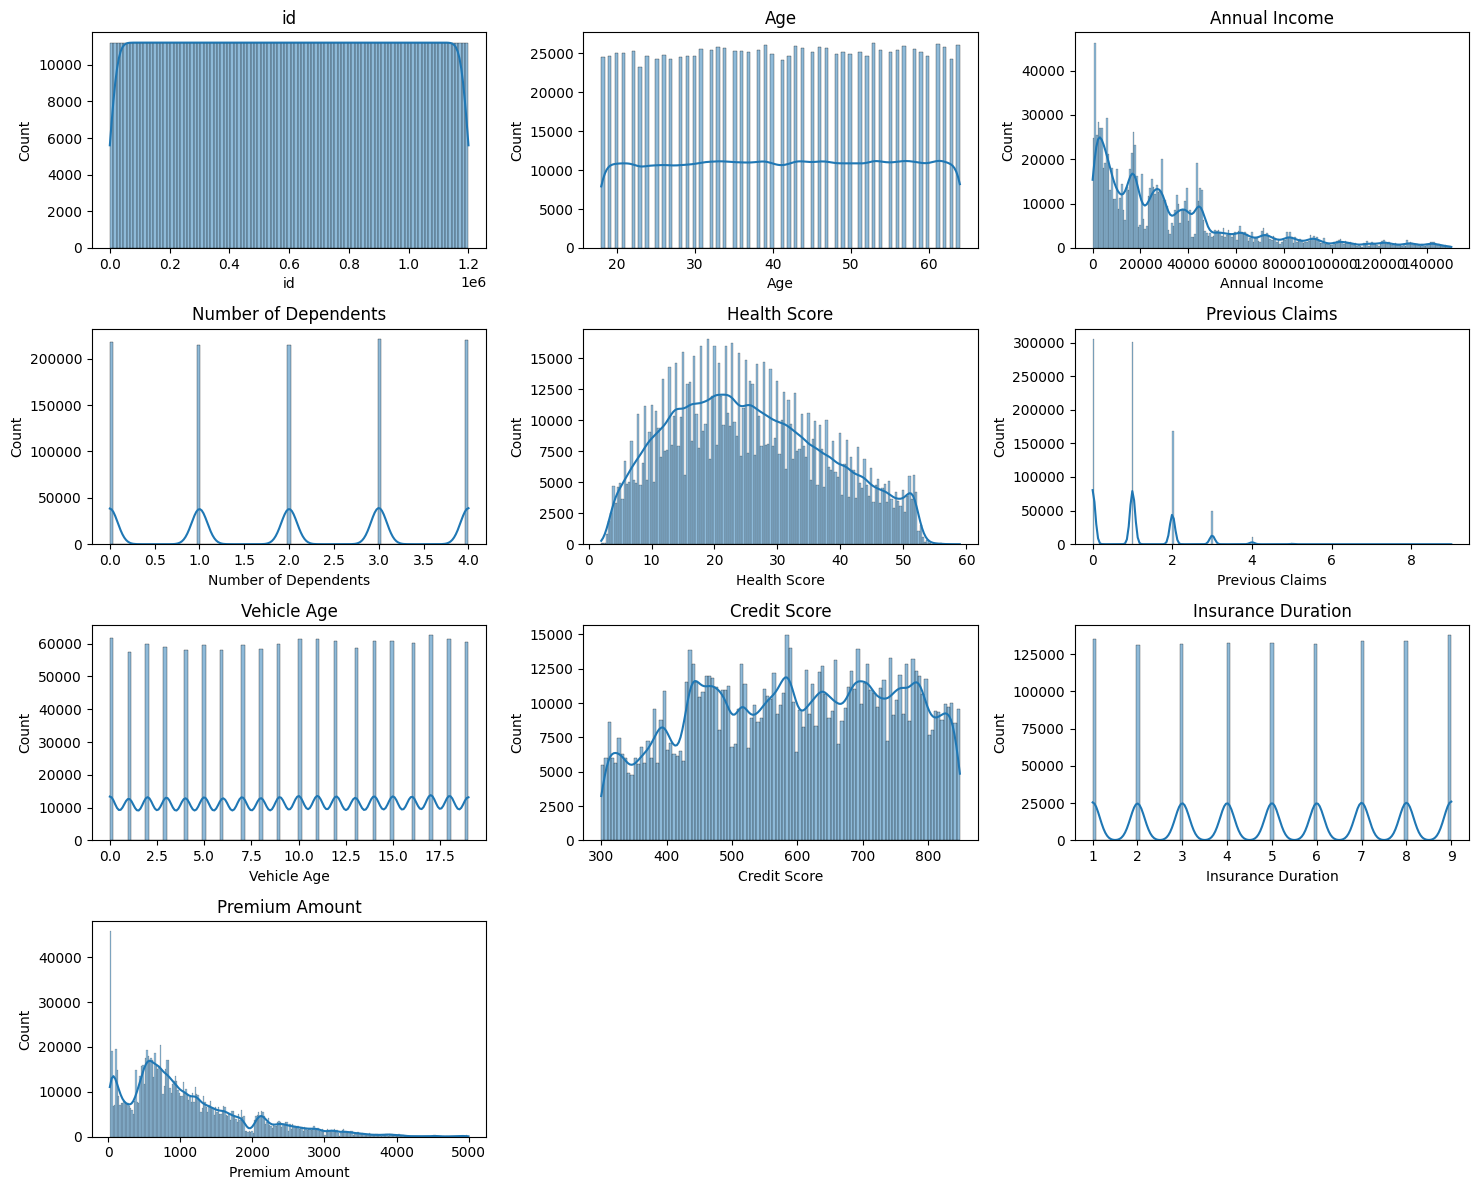

In [7]:
# Визуализация гистограмм
def plot_histograms(df):
    # Определить количество строк и столбцов для подграфиков
    n_cols = 3
    n_rows = (len(df.columns) + n_cols - 1) // n_cols
    
    # Создать фигуру с нужным размером
    plt.figure(figsize=(n_cols * 5, n_rows * 3))
    
    for i, column in enumerate(df.columns, start=1):
        plt.subplot(n_rows, n_cols, i)
        sns.histplot(df[column], kde=True)
        
        # Добавить название столбца как заголовок графика
        plt.title(column)
        
    plt.tight_layout()
    plt.show()

# Применение функции к DataFrame df
plot_histograms(df[col_num])

In [8]:
col_cat = df.select_dtypes(include=["object"]).columns
eda_cat_info(df[col_cat])

,Доля пропусков,Количество уникальных значений,Мода
Gender,0.000000,2,Male
Marital Status,0.015441,3,Single
Education Level,0.000000,4,Master's
Occupation,0.298396,3,Employed
Location,0.000000,3,Suburban
Policy Type,0.000000,3,Premium
Policy Start Date,0.000000,167381,2020-02-08 15:21:39.134960
Customer Feedback,0.064853,3,Average
Smoking Status,0.000000,2,Yes
Exercise Frequency,0.000000,4,Weekly


Данные столбца *Policy Start Date* - дата начала действия страхового полиса - будет сложно использовать при обучении модели регрессии, поэтому данный столбец удалим. По остальным столбцам видно, что имеются пропуски, будем исправлять.

In [9]:
df = df.drop(columns=["Policy Start Date"])

In [10]:
col_cat = df.select_dtypes(include=["object"]).columns
eda_cat_info(df[col_cat])

,Доля пропусков,Количество уникальных значений,Мода
Gender,0.000000,2,Male
Marital Status,0.015441,3,Single
Education Level,0.000000,4,Master's
Occupation,0.298396,3,Employed
Location,0.000000,3,Suburban
Policy Type,0.000000,3,Premium
Customer Feedback,0.064853,3,Average
Smoking Status,0.000000,2,Yes
Exercise Frequency,0.000000,4,Weekly
Property Type,0.000000,3,House


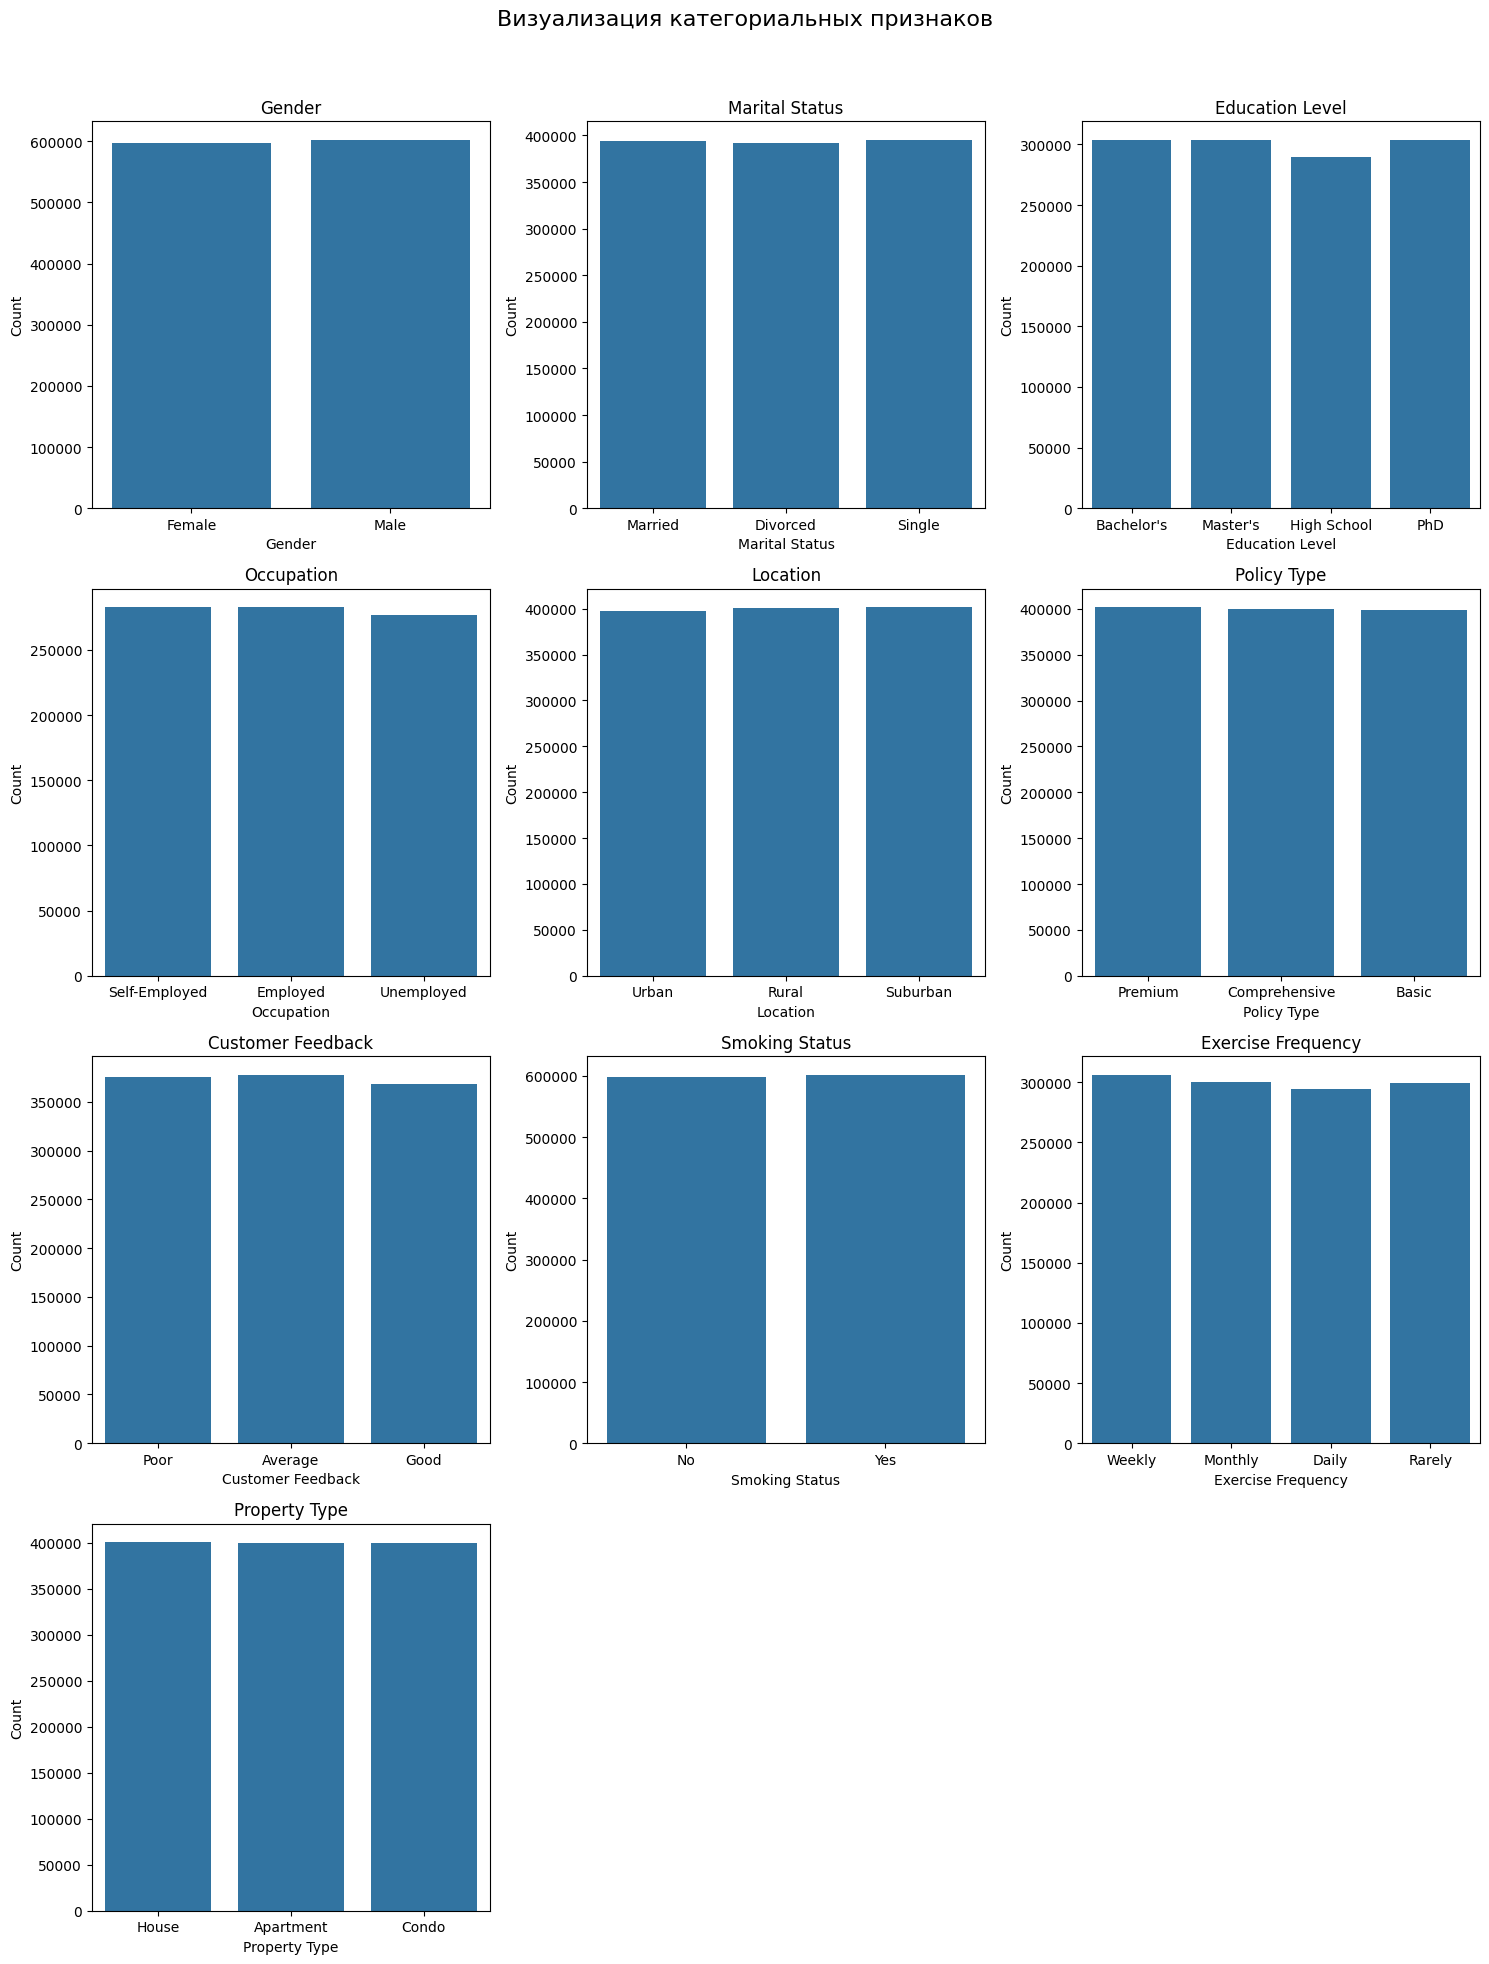

In [11]:
# Определение количества строк и столбцов для сетки
n = len(col_cat)
ncols = 3  # Количество столбцов в сетке
nrows = (n + ncols - 1) // ncols  # Количество строк

# Создание фигуры и подграфиков
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 5 * nrows))
axes = axes.flatten()  # Преобразование в одномерный массив для удобства

# Создание столбчатой диаграммы для каждого категориального столбца
for i, column in enumerate(col_cat):
    sns.countplot(data=df, x=column, ax=axes[i])
    axes[i].set_title(column)  # Заголовок для каждого графика
    axes[i].set_xlabel(column)  # Подпись оси X
    axes[i].set_ylabel('Count')  # Подпись оси Y

# Удаление пустых подграфиков, если они есть
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Добавление заголовка к сетке графиков
fig.suptitle('Визуализация категориальных признаков', fontsize=16)

plt.tight_layout(rect=[0, 0, 1, 0.96])  # Автоматическая настройка отступов
plt.show()  # Отображение графиков

## Подготовка датасета к построению моделей ML

### Целевая переменная

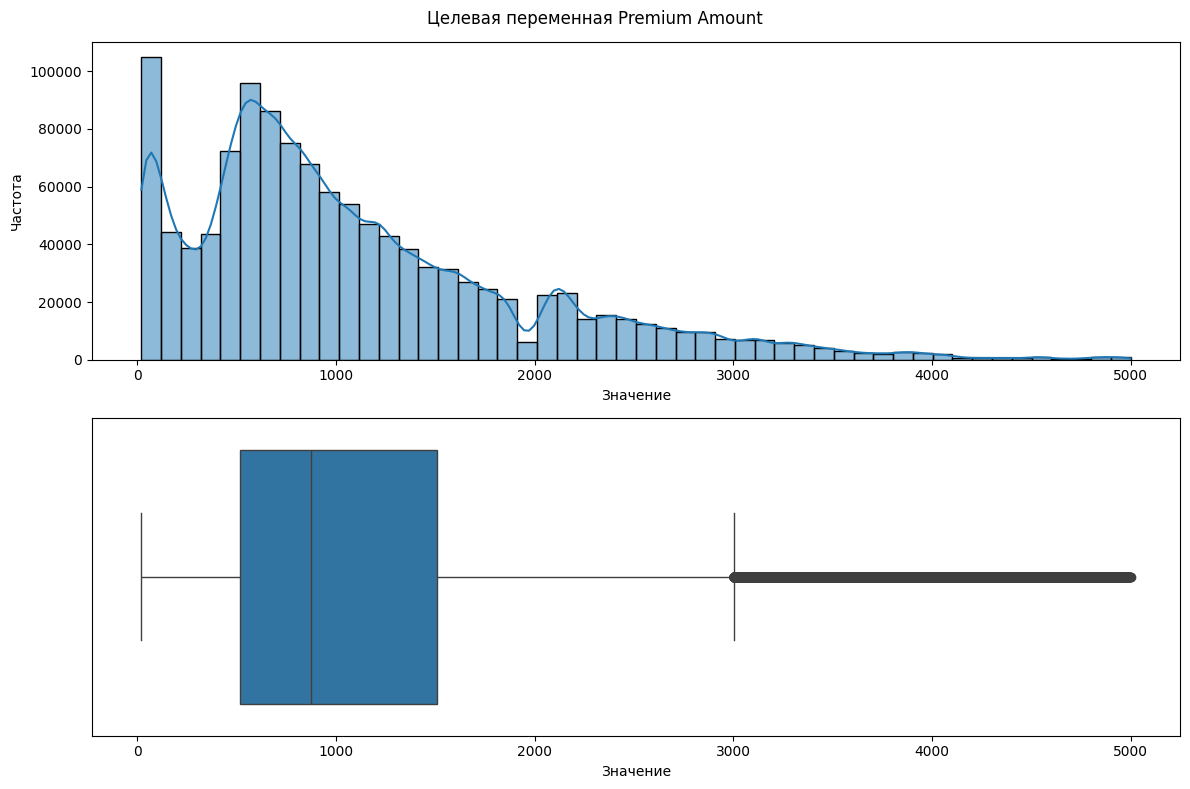

In [12]:
# Распределение целевой переменной
fig, ax = plt.subplots(2, 1, figsize=(12, 8))

sns.histplot(df['Premium Amount'], bins=50, kde=True, ax=ax[0])
ax[0].set_xlabel("Значение")
ax[0].set_ylabel("Частота")

sns.boxplot(df['Premium Amount'], orient="h", ax=ax[1])
ax[1].set_xlabel("Значение")
ax[1].set_yticks([])

plt.suptitle("Целевая переменная Premium Amount")
plt.tight_layout()
plt.show()

Видим, что имеются выбросы, но если их удалить, то потеряется достаточно много полезной информации. Оставим как есть.

### Обработка пропусков

In [13]:
print("Количество пропусков в числовых столбцах:")
print(df[col_num].isnull().sum())
print("\nКоличество пропусков в категориальных столбцах:")
print(df[col_cat].isnull().sum())

Количество пропусков в числовых столбцах:
id                           0
Age                      18705
Annual Income            44949
Number of Dependents    109672
Health Score             74076
Previous Claims         364029
Vehicle Age                  6
Credit Score            137882
Insurance Duration           1
Premium Amount               0
dtype: int64

Количество пропусков в категориальных столбцах:
Gender                     0
Marital Status         18529
Education Level            0
Occupation            358075
Location                   0
Policy Type                0
Customer Feedback      77824
Smoking Status             0
Exercise Frequency         0
Property Type              0
dtype: int64


In [14]:
# Заполняем пропуски числовых переменных медианой
df[col_num] = df[col_num].fillna(df[col_num].median())

In [15]:
# Заполненяем пропуски модой для категориальных столбцов
for column in col_cat:
    mode_value = df[column].mode()[0]  # Получение моды
    df.fillna({column: mode_value}, inplace=True)  # Заполнение пропусков модой

In [16]:
print("Количество пропусков в числовых столбцах:")
print(df[col_num].isnull().sum())
print("\nКоличество пропусков в категориальных столбцах:")
print(df[col_cat].isnull().sum())

Количество пропусков в числовых столбцах:
id                      0
Age                     0
Annual Income           0
Number of Dependents    0
Health Score            0
Previous Claims         0
Vehicle Age             0
Credit Score            0
Insurance Duration      0
Premium Amount          0
dtype: int64

Количество пропусков в категориальных столбцах:
Gender                0
Marital Status        0
Education Level       0
Occupation            0
Location              0
Policy Type           0
Customer Feedback     0
Smoking Status        0
Exercise Frequency    0
Property Type         0
dtype: int64


### Обработка выбросов

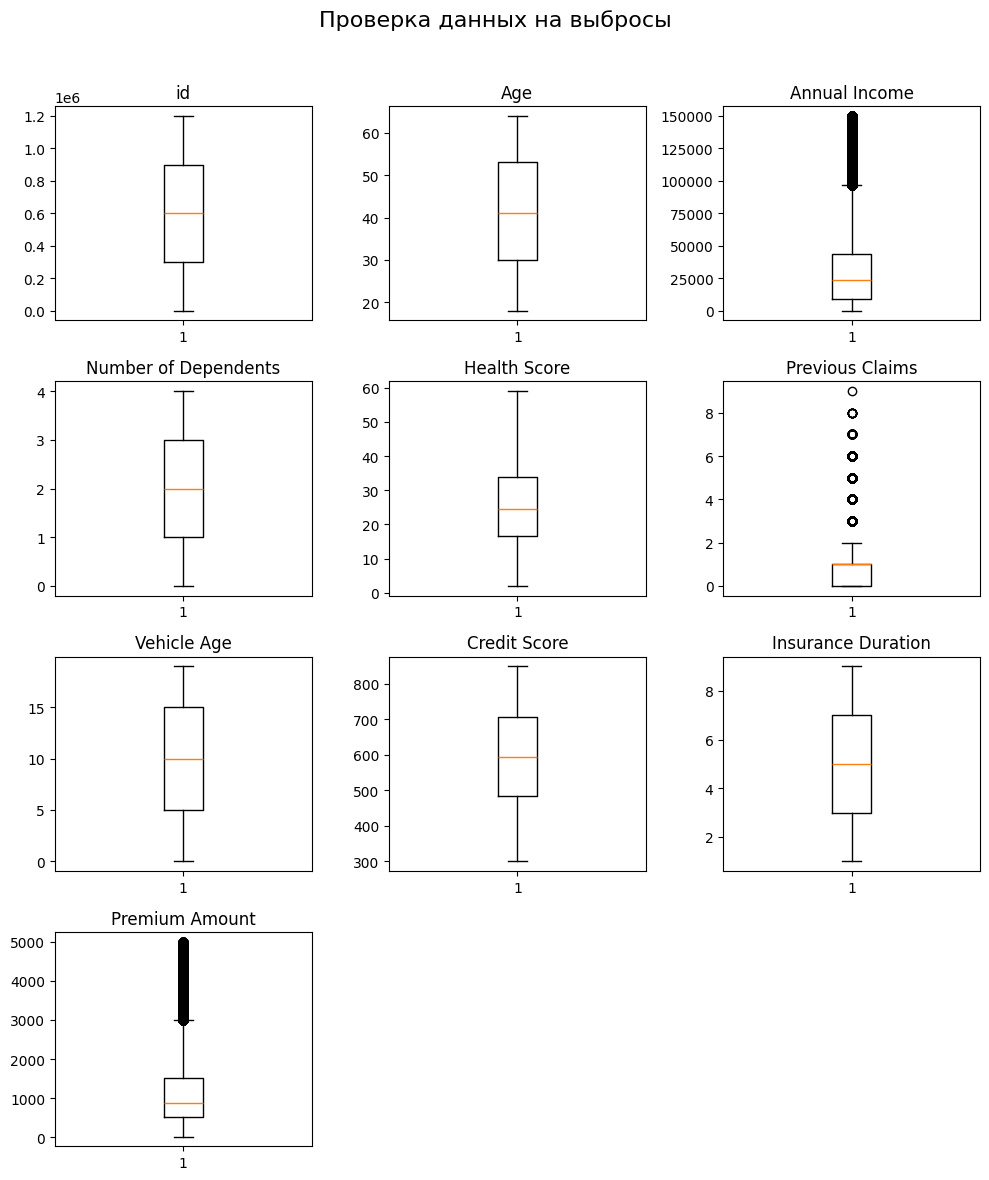

In [17]:
n = len(col_num)
ncols = 3  # Количество столбцов в сетке
nrows = (n + ncols - 1) // ncols  # Количество строк

# Создание фигуры и подграфиков
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(10, 3 * nrows))
axes = axes.flatten()  # Преобразование в одномерный массив для удобства

# Создание boxplot для каждого числового столбца
for i, column in enumerate(col_num):
    axes[i].boxplot(df[column])
    axes[i].set_title(column)  # Заголовок для каждого графика

# Удаление пустых подграфиков, если они есть
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])
    
fig.suptitle("Проверка данных на выбросы", fontsize=16)

plt.tight_layout(rect=[0, 0, 1, 0.96])  # Автоматическая настройка отступов
plt.show()  # Отображение графиков

In [18]:
df['Annual Income'].sort_values(ascending=False).head()

427875    149997.0
167855    149997.0
585837    149996.0
111026    149996.0
88801     149996.0
Name: Annual Income, dtype: float64

In [19]:
df['Annual Income'].sort_values().head()

1013454    1.0
522743     2.0
655980     2.0
63472      2.0
571779     2.0
Name: Annual Income, dtype: float64

In [20]:
df['Previous Claims'].sort_values().unique()

array([0., 1., 2., 3., 4., 5., 6., 7., 8., 9.])

Большое количество выбросов видно в столбце *Annual Income*. Значения принимаются от 1 до 149997. Заменим выбросы с помощью помощью метода интерквантильного размаха. Столбец *Previus Claims* оставим без изменений, видим что там идет нормальное распределение значений.

In [21]:
# Обработаем выбросы
def outliers_in_data(df, columns):
    for col in columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower = df[col].quantile(0.1)
        upper = Q3 + 1.5 * IQR
        df[col] = np.where(df[col] < lower, lower, df[col])
        df[col] = np.where(df[col] > upper, upper, df[col])
    
    return df


df = outliers_in_data(df, ['Annual Income'])

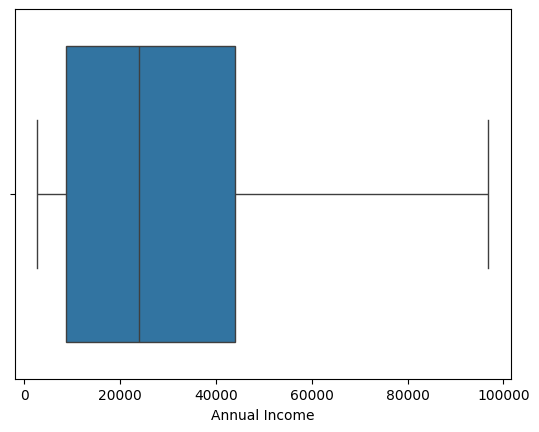

In [22]:
sns.boxplot(data=df, x='Annual Income')
plt.show()

In [23]:
df['Annual Income'].sort_values(ascending=False).head()

329780    96871.0
205017    96871.0
995192    96871.0
398614    96871.0
995189    96871.0
Name: Annual Income, dtype: float64

In [24]:
df['Annual Income'].sort_values().head()

924112     2699.0
1019079    2699.0
96617      2699.0
96616      2699.0
363402     2699.0
Name: Annual Income, dtype: float64

## Проведем EDA после обработки данных

In [25]:
eda_num_info(df[col_num])

,Доля пропусков,Минимальное значение,Максимальное значение,Среднее значение,Медиана,Дисперсия,Квантиль 0.1,Квантиль 0.9,Квартиль 1,Квартиль 3
id,0.0,0.000000,1.199999e+06,599999.500000,599999.500000,1.200001e+11,119999.900000,1.079999e+06,299999.750000,899999.25000
Age,0.0,18.000000,6.400000e+01,41.143294,41.000000,1.804729e+02,22.000000,6.000000e+01,30.000000,53.00000
Annual Income,0.0,2699.000000,9.687100e+04,31122.853124,23911.000000,7.576032e+08,2699.000000,7.944810e+04,8646.000000,43936.00000
Number of Dependents,0.0,0.000000,4.000000e+00,2.009026,2.000000,1.825259e+00,0.000000,4.000000e+00,1.000000,3.00000
Health Score,0.0,2.012237,5.897591e+01,25.550001,24.578648,1.397934e+02,10.185439,4.284583e+01,16.554572,33.77289
Previous Claims,0.0,0.000000,9.000000e+00,1.001873,1.000000,6.729404e-01,0.000000,2.000000e+00,0.000000,1.00000
Vehicle Age,0.0,0.000000,1.900000e+01,9.569891,10.000000,3.336419e+01,2.000000,1.800000e+01,5.000000,15.00000
Credit Score,0.0,300.000000,8.490000e+02,593.162846,595.000000,1.991035e+04,393.000000,7.870000e+02,484.000000,706.00000
Insurance Duration,0.0,1.000000,9.000000e+00,5.018219,5.000000,6.730550e+00,1.000000,9.000000e+00,3.000000,7.00000
Premium Amount,0.0,20.000000,4.999000e+03,1102.544822,872.000000,7.482230e+05,150.000000,2.363000e+03,514.000000,1509.00000


In [26]:
eda_cat_info(df[col_cat])

,Доля пропусков,Количество уникальных значений,Мода
Gender,0.0,2,Male
Marital Status,0.0,3,Single
Education Level,0.0,4,Master's
Occupation,0.0,3,Employed
Location,0.0,3,Suburban
Policy Type,0.0,3,Premium
Customer Feedback,0.0,3,Average
Smoking Status,0.0,2,Yes
Exercise Frequency,0.0,4,Weekly
Property Type,0.0,3,House


In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1200000 entries, 0 to 1199999
Data columns (total 20 columns):
 #   Column                Non-Null Count    Dtype  
---  ------                --------------    -----  
 0   id                    1200000 non-null  int64  
 1   Age                   1200000 non-null  float64
 2   Gender                1200000 non-null  object 
 3   Annual Income         1200000 non-null  float64
 4   Marital Status        1200000 non-null  object 
 5   Number of Dependents  1200000 non-null  float64
 6   Education Level       1200000 non-null  object 
 7   Occupation            1200000 non-null  object 
 8   Health Score          1200000 non-null  float64
 9   Location              1200000 non-null  object 
 10  Policy Type           1200000 non-null  object 
 11  Previous Claims       1200000 non-null  float64
 12  Vehicle Age           1200000 non-null  float64
 13  Credit Score          1200000 non-null  float64
 14  Insurance Duration    1200000 non-

Пропуски и выбросы обработаны.

## Построим матрицу корреляций

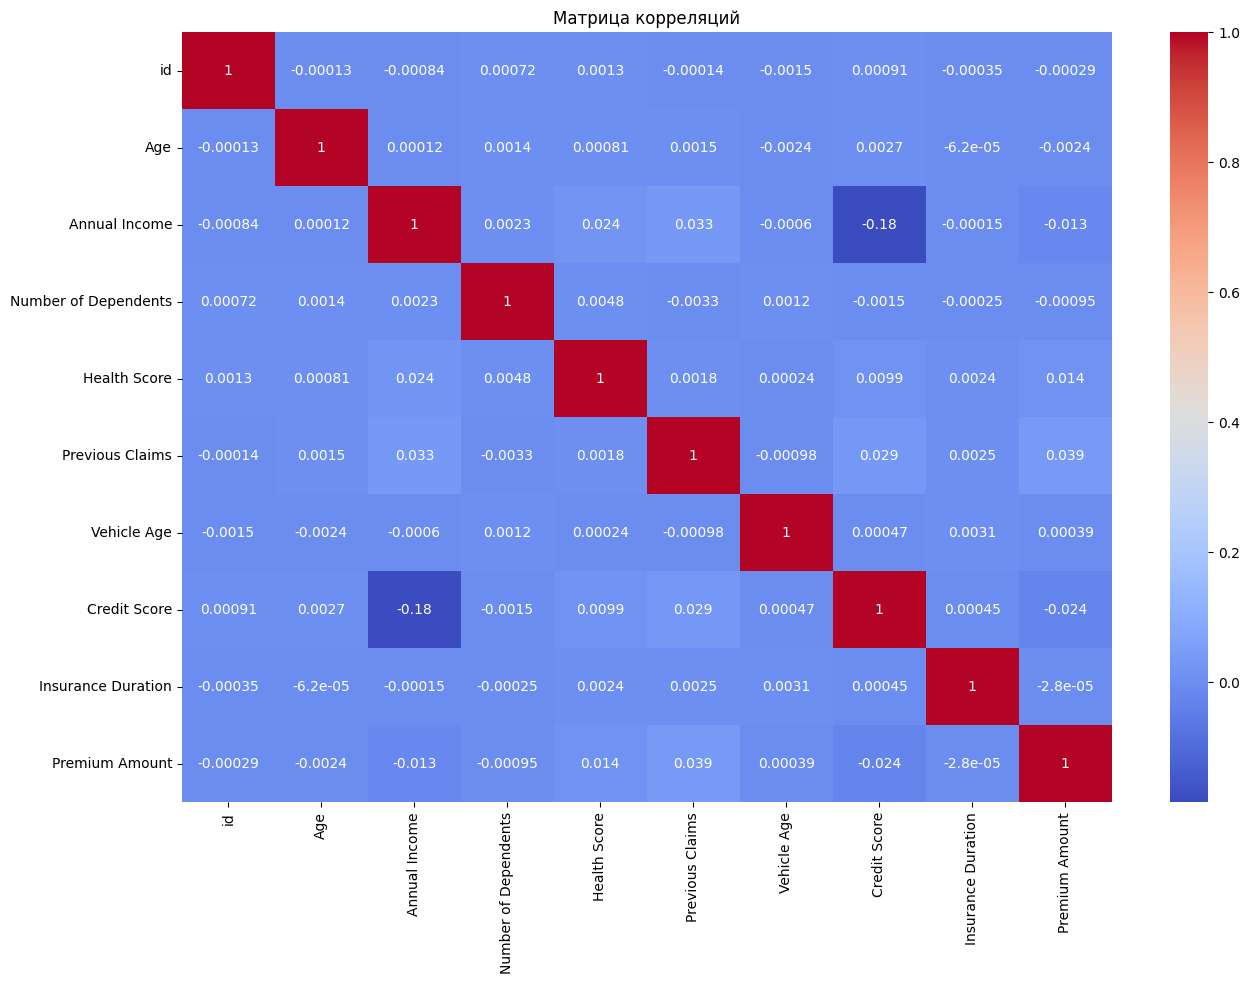

In [28]:
corr = df[col_num].corr()
plt.figure(figsize=(15,10))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title("Матрица корреляций")
plt.show()

Явных корреляций не заметно.

## Уменьшаем исходный датасет

**Уменьшим датасет до 10000 строк:**

- `Квантильная группировка`: Используем *pd.qcut* для разделения целевой переменной на 10 квантильных групп.

- `Стратифицированная выборка`: выберем 10000 строк, сохраняя распределение как в исходной выборке.

Таким образом мы получаем уменьшенную копию нашего датасета.

In [29]:
df['Premium_Amount_quantile'] = pd.qcut(df['Premium Amount'], q=10, duplicates='drop')

In [30]:
# Стратифицированный train_test_split для регрессионной задачи
_, df_short = train_test_split(df, test_size=10000, stratify=df['Premium_Amount_quantile'], random_state=42)

# Удалим вспомогательный столбец
df_short = df_short.drop(columns='Premium_Amount_quantile')
df_short.head()

,id,Age,Gender,Annual Income,Marital Status,Number of Dependents,Education Level,Occupation,Health Score,Location,Policy Type,Previous Claims,Vehicle Age,Credit Score,Insurance Duration,Customer Feedback,Smoking Status,Exercise Frequency,Property Type,Premium Amount
217841,217841,62.0,Male,52086.0,Single,4.0,High School,Self-Employed,32.382309,Urban,Premium,3.0,7.0,462.0,6.0,Poor,No,Daily,House,175.0
1120248,1120248,55.0,Female,63789.0,Divorced,3.0,Bachelor's,Employed,45.981148,Rural,Comprehensive,1.0,10.0,308.0,4.0,Poor,Yes,Daily,House,1114.0
37577,37577,47.0,Male,48262.0,Single,1.0,Master's,Employed,11.273853,Urban,Premium,1.0,18.0,340.0,1.0,Poor,No,Rarely,House,469.0
1164385,1164385,28.0,Female,2699.0,Married,1.0,Bachelor's,Employed,30.999345,Rural,Premium,2.0,0.0,569.0,7.0,Poor,No,Rarely,House,1166.0
84246,84246,40.0,Female,5907.0,Married,1.0,Master's,Employed,27.527508,Urban,Premium,1.0,7.0,595.0,6.0,Poor,No,Daily,House,498.0


In [31]:
# Выводим информацию о новом датасете
print("Исходный размер датасета:", df.shape)
print("Размер уменьшенного датасета:", df_short.shape)
print("Распределение целевой переменной в начальном датасете:")
print(df['Premium Amount'].describe())
print("Распределение целевой переменной в уменьшенном датасете:")
print(df_short['Premium Amount'].describe())

Исходный размер датасета: (1200000, 21)
Размер уменьшенного датасета: (10000, 20)
Распределение целевой переменной в начальном датасете:
count    1.200000e+06
mean     1.102545e+03
std      8.649989e+02
min      2.000000e+01
25%      5.140000e+02
50%      8.720000e+02
75%      1.509000e+03
max      4.999000e+03
Name: Premium Amount, dtype: float64
Распределение целевой переменной в уменьшенном датасете:
count    10000.000000
mean      1102.458400
std        863.569741
min         20.000000
25%        513.000000
50%        872.000000
75%       1515.000000
max       4980.000000
Name: Premium Amount, dtype: float64


In [32]:
df_short.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10000 entries, 217841 to 850615
Data columns (total 20 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   id                    10000 non-null  int64  
 1   Age                   10000 non-null  float64
 2   Gender                10000 non-null  object 
 3   Annual Income         10000 non-null  float64
 4   Marital Status        10000 non-null  object 
 5   Number of Dependents  10000 non-null  float64
 6   Education Level       10000 non-null  object 
 7   Occupation            10000 non-null  object 
 8   Health Score          10000 non-null  float64
 9   Location              10000 non-null  object 
 10  Policy Type           10000 non-null  object 
 11  Previous Claims       10000 non-null  float64
 12  Vehicle Age           10000 non-null  float64
 13  Credit Score          10000 non-null  float64
 14  Insurance Duration    10000 non-null  float64
 15  Customer Feedback 

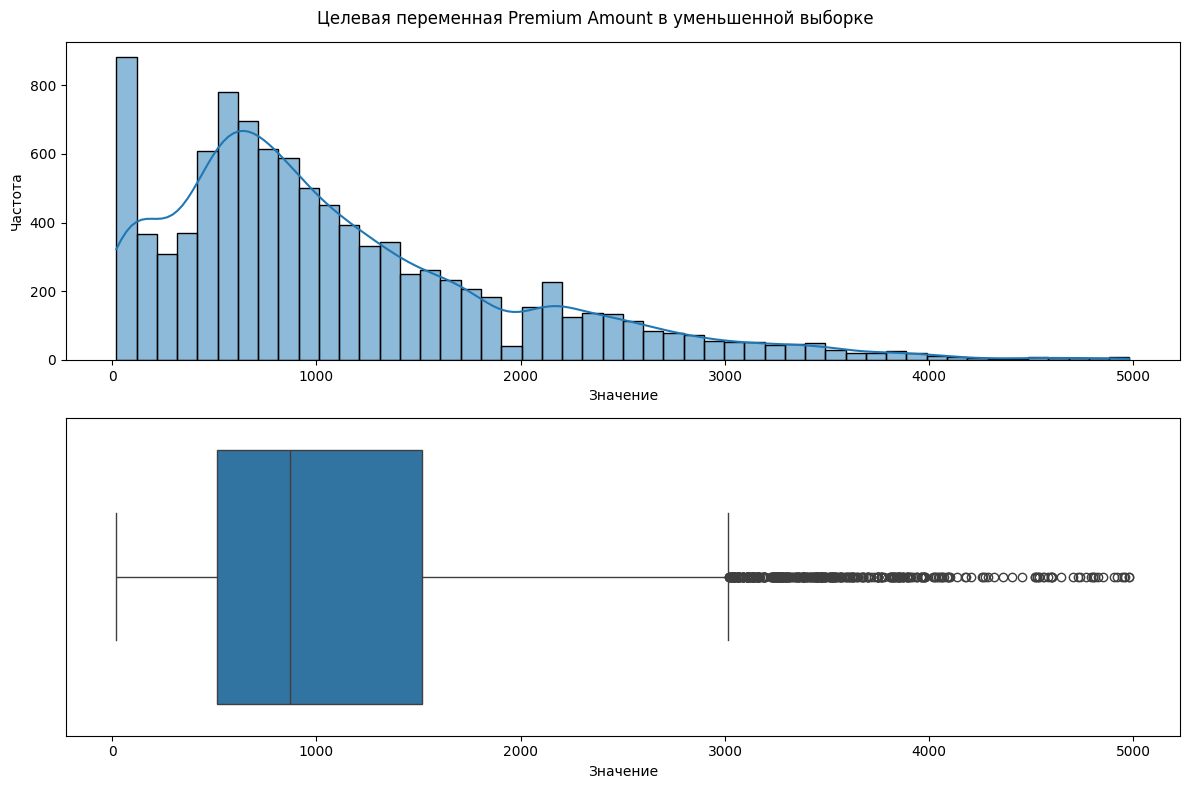

In [33]:
# Распределение целевой переменной
fig, ax = plt.subplots(2, 1, figsize=(12, 8))

sns.histplot(df_short['Premium Amount'], bins=50, kde=True, ax=ax[0])
ax[0].set_xlabel("Значение")
ax[0].set_ylabel("Частота")

sns.boxplot(df_short['Premium Amount'], orient="h", ax=ax[1])
ax[1].set_xlabel("Значение")
ax[1].set_yticks([])

plt.suptitle("Целевая переменная Premium Amount в уменьшенной выборке")
plt.tight_layout()
plt.show()

Графики распределения целевой переменной для полной и уменьшенной выборок идентичные.

In [66]:
# Сохраним уменьшенный датасет на диск
df_short.to_csv("./train_10000.csv", index=False)

## Кодирование категориальных признаков

In [35]:
# Используем метод OneHotEncoding
df_short_ohe = pd.get_dummies(df_short, columns=col_cat, drop_first=True, dtype=int)

df_short_ohe.head()

,id,Age,Annual Income,Number of Dependents,Health Score,Previous Claims,Vehicle Age,Credit Score,Insurance Duration,Premium Amount,Gender_Male,Marital Status_Married,Marital Status_Single,Education Level_High School,Education Level_Master's,Education Level_PhD,Occupation_Self-Employed,Occupation_Unemployed,Location_Suburban,Location_Urban,Policy Type_Comprehensive,Policy Type_Premium,Customer Feedback_Good,Customer Feedback_Poor,Smoking Status_Yes,Exercise Frequency_Monthly,Exercise Frequency_Rarely,Exercise Frequency_Weekly,Property Type_Condo,Property Type_House
217841,217841,62.0,52086.0,4.0,32.382309,3.0,7.0,462.0,6.0,175.0,1,0,1,1,0,0,1,0,0,1,0,1,0,1,0,0,0,0,0,1
1120248,1120248,55.0,63789.0,3.0,45.981148,1.0,10.0,308.0,4.0,1114.0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,1,0,0,0,0,1
37577,37577,47.0,48262.0,1.0,11.273853,1.0,18.0,340.0,1.0,469.0,1,0,1,0,1,0,0,0,0,1,0,1,0,1,0,0,1,0,0,1
1164385,1164385,28.0,2699.0,1.0,30.999345,2.0,0.0,569.0,7.0,1166.0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,1
84246,84246,40.0,5907.0,1.0,27.527508,1.0,7.0,595.0,6.0,498.0,0,1,0,0,1,0,0,0,0,1,0,1,0,1,0,0,0,0,0,1


## Разделим на тренировочную и тестовую выборки

In [36]:
X = df_short_ohe.drop(columns=['id', 'Premium Amount'])
y = df_short_ohe['Premium Amount']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print('Размер тренировочной выборки (признаки):', X_train.shape)
print('Размер тестовой выборки (признаки):', X_test.shape)
print('Размер тренировочной выборки (целевой признак):', y_train.shape)
print('Размер тестовой выборки (целевой признак):', y_test.shape)

Размер тренировочной выборки (признаки): (8000, 28)
Размер тестовой выборки (признаки): (2000, 28)
Размер тренировочной выборки (целевой признак): (8000,)
Размер тестовой выборки (целевой признак): (2000,)


## Регрессия Random Forest (без генерации признаков)

In [37]:
# Определяем сетку гиперпараметров Регрессии Random Forest
param_grid_rf = {
    'max_depth': [None] + [i for i in range(1, 10, 2)],
    'min_samples_split': [2, 4, 6, 8],
    'min_samples_leaf': [1, 2, 3, 4],
    'ccp_alpha': [0.01, 0.02, 0.03]
}

In [38]:
# Создаем модель случайного леса
rf_model = RandomForestRegressor(random_state=42)

# Создаем объект RandomizedSearchCV c сеткой параметров
random_search_rf = RandomizedSearchCV(
    rf_model,
    param_grid_rf,
    n_iter=30, 
    cv=3,  
    scoring='neg_mean_squared_error',
    n_jobs=-1,  
    random_state=42
)

# Запускаем подбор параметров
random_search_rf.fit(X_train, y_train)

# Выводим лучшие параметры
print("Лучшие параметры:", random_search_rf.best_params_)

# Финальная модель
best_rf_reg = random_search_rf.best_estimator_

Лучшие параметры: {'min_samples_split': 2, 'min_samples_leaf': 3, 'max_depth': 5, 'ccp_alpha': 0.01}


In [39]:
rf_pred_best = best_rf_reg.predict(X_test)

In [40]:
# Оценка качества
mse_rf = mean_squared_error(y_test, rf_pred_best)
rmse_rf = root_mean_squared_error(y_test, rf_pred_best)
r2_rf = r2_score(y_test, rf_pred_best)
mae_rf = mean_absolute_error(y_test, rf_pred_best)

print('MSE (без генерации признаков):', mse_rf)
print('RMSE (без генерации признаков):', rmse_rf)
print('R2 (без генерации признаков):', r2_rf)
print('MAE (без генерации признаков):', mae_rf)

MSE (без генерации признаков): 710322.8564866123
RMSE (без генерации признаков): 842.8065356216765
R2 (без генерации признаков): 0.026891948732696958
MAE (без генерации признаков): 649.0311110310727


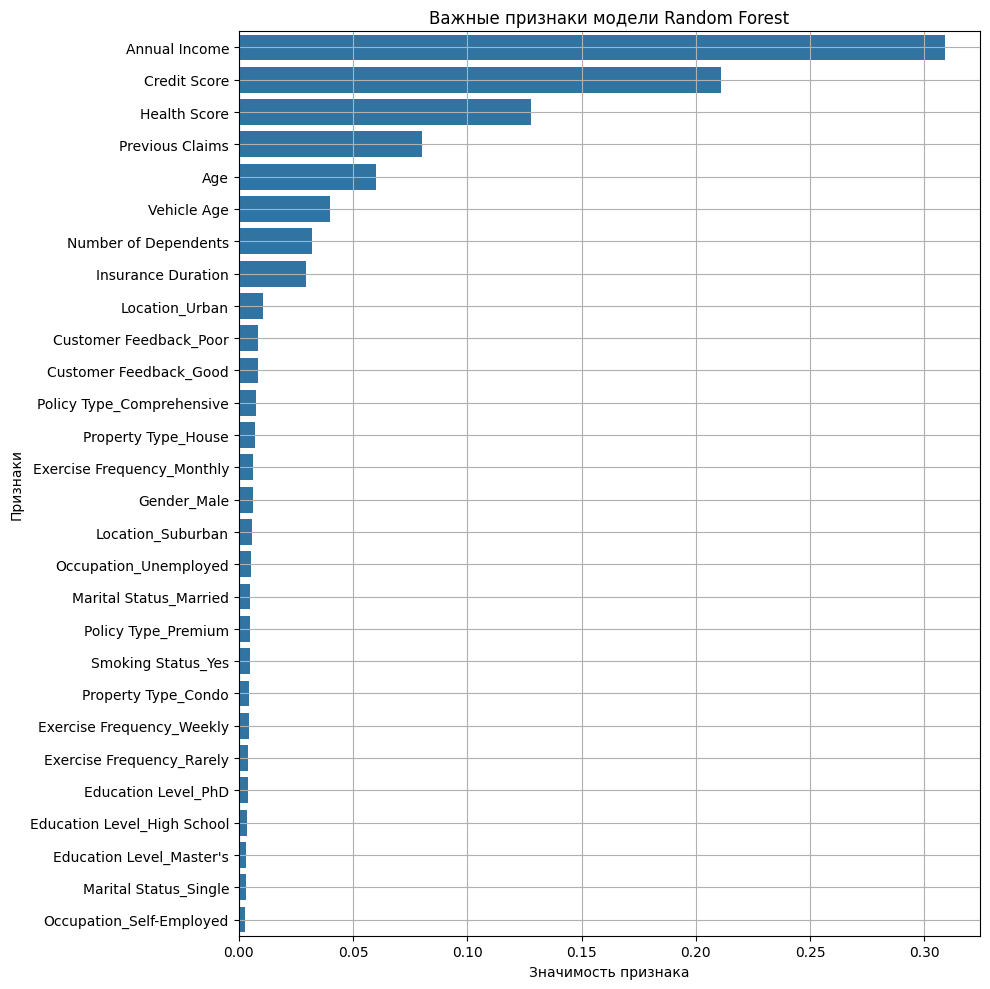

In [41]:
feature_imp = pd.DataFrame(
    sorted(zip(best_rf_reg.feature_importances_, X.columns)),
    columns=['Значимость признака','Признаки'])

plt.figure(figsize=(10, 10))
sns.barplot(x="Значимость признака",
            y="Признаки",
            data=feature_imp.sort_values(
                by="Значимость признака",
                ascending=False)
            )
plt.title('Важные признаки модели Random Forest')
plt.tight_layout()
plt.grid()
plt.show()

Для Случайного Леса топ 4 важных признака: `Annual Income, Credit Score, Health Score, Previous Claim`.

## Генерация признаков (Feature-engine)

In [42]:
X = df_short.drop(columns=['id', 'Premium Amount'])
y = df_short['Premium Amount']

print('Размер X:', X.shape)
print('Размер y:', y.shape)

Размер X: (10000, 18)
Размер y: (10000,)


In [43]:
cat_features = X.select_dtypes(include=["object", "category"]).columns.tolist()
num_features = X.select_dtypes(include=["int64", "float64"]).columns.tolist()

print('Категориальные столбцы:', cat_features)
print('Числовые столбцы:', num_features)

Категориальные столбцы: ['Gender', 'Marital Status', 'Education Level', 'Occupation', 'Location', 'Policy Type', 'Customer Feedback', 'Smoking Status', 'Exercise Frequency', 'Property Type']
Числовые столбцы: ['Age', 'Annual Income', 'Number of Dependents', 'Health Score', 'Previous Claims', 'Vehicle Age', 'Credit Score', 'Insurance Duration']


In [44]:
# Удалим редкие категории (меньше 5% объектов)
if cat_features:
    rare_encoder = RareLabelEncoder(tol=0.05, n_categories=1, variables=cat_features)
    X = rare_encoder.fit_transform(X)

    # One-hot кодирование
    onehot_encoder = OneHotEncoder(variables=cat_features, drop_last=True)
    X = onehot_encoder.fit_transform(X)

Команды:

- add -	сложение (x + y)
- sub -	вычитание (x - y)
- mul - умножение (x * y)
- div - деление (x / y) — эквивалент truediv
- pow - возведение в степень (x ** y)
- mod - остаток от деления (x % y)
- floordiv - целочисленное деление (x // y)

In [45]:
# Генерация относительных признаков
relative_creator = RelativeFeatures(
    variables=num_features,
    reference=num_features,
    func=["div", "sub", "add"],
    drop_original=False,
    missing_values="ignore",
    fill_value=1e-5  # Заменяем нули перед операцией, чтобы избежать деления на ноль
)

X_rel = relative_creator.fit_transform(X)

In [46]:
# Фильтрация
# Удалим признаки с бесконечными значениями
X_rel = X_rel.replace([np.inf, -np.inf], np.nan).dropna(axis=1)

# Удалим признаки, где более 95% значений — нули
non_zero_ratio = (X_rel != 0).mean()
X_rel = X_rel.loc[:, non_zero_ratio > 0.05]

# Удалим признаки, где переменная сравнивалась сама с собой
X_rel = X_rel.loc[:, ~X_rel.columns.str.contains(r'([a-zA-Z0-9_]+)_(div|sub|add)_\1')]

# Объединяем
X_final = pd.concat([X, X_rel], axis=1)

In [47]:
X_final.head()

,Age,Annual Income,Number of Dependents,Health Score,Previous Claims,Vehicle Age,Credit Score,Insurance Duration,Gender_Male,Marital Status_Single,Marital Status_Divorced,Education Level_High School,Education Level_Bachelor's,Education Level_Master's,Occupation_Self-Employed,Occupation_Employed,Location_Urban,Location_Rural,Policy Type_Premium,Policy Type_Comprehensive,Customer Feedback_Poor,Customer Feedback_Average,Smoking Status_No,Exercise Frequency_Daily,Exercise Frequency_Rarely,Exercise Frequency_Monthly,Property Type_House,Property Type_Apartment,Age,Annual Income,Number of Dependents,Health Score,Previous Claims,Vehicle Age,Credit Score,Insurance Duration,Gender_Male,Marital Status_Single,Marital Status_Divorced,Education Level_High School,Education Level_Bachelor's,Education Level_Master's,Occupation_Self-Employed,Occupation_Employed,Location_Urban,Location_Rural,Policy Type_Premium,Policy Type_Comprehensive,Customer Feedback_Poor,Customer Feedback_Average,Smoking Status_No,Exercise Frequency_Daily,Exercise Frequency_Rarely,Exercise Frequency_Monthly,Property Type_House,Property Type_Apartment,Annual Income_div_Age,Number of Dependents_div_Age,Health Score_div_Age,Previous Claims_div_Age,Credit Score_div_Age,Insurance Duration_div_Age,Age_div_Annual Income,Annual Income_div_Annual Income,Number of Dependents_div_Annual Income,Health Score_div_Annual Income,Previous Claims_div_Annual Income,Vehicle Age_div_Annual Income,Credit Score_div_Annual Income,Insurance Duration_div_Annual Income,Age_div_Number of Dependents,Annual Income_div_Number of Dependents,Number of Dependents_div_Number of Dependents,Health Score_div_Number of Dependents,Previous Claims_div_Number of Dependents,Vehicle Age_div_Number of Dependents,Credit Score_div_Number of Dependents,Insurance Duration_div_Number of Dependents,Age_div_Health Score,Annual Income_div_Health Score,Number of Dependents_div_Health Score,Health Score_div_Health Score,Previous Claims_div_Health Score,Vehicle Age_div_Health Score,Credit Score_div_Health Score,Insurance Duration_div_Health Score,Age_div_Previous Claims,Annual Income_div_Previous Claims,Number of Dependents_div_Previous Claims,Health Score_div_Previous Claims,Previous Claims_div_Previous Claims,Vehicle Age_div_Previous Claims,Credit Score_div_Previous Claims,Insurance Duration_div_Previous Claims,Age_div_Vehicle Age,Annual Income_div_Vehicle Age,Number of Dependents_div_Vehicle Age,Health Score_div_Vehicle Age,Previous Claims_div_Vehicle Age,Vehicle Age_div_Vehicle Age,Credit Score_div_Vehicle Age,Insurance Duration_div_Vehicle Age,Age_div_Credit Score,Annual Income_div_Credit Score,Number of Dependents_div_Credit Score,Health Score_div_Credit Score,Previous Claims_div_Credit Score,Vehicle Age_div_Credit Score,Credit Score_div_Credit Score,Insurance Duration_div_Credit Score,Age_div_Insurance Duration,Annual Income_div_Insurance Duration,Number of Dependents_div_Insurance Duration,Health Score_div_Insurance Duration,Previous Claims_div_Insurance Duration,Vehicle Age_div_Insurance Duration,Credit Score_div_Insurance Duration,Insurance Duration_div_Insurance Duration,Annual Income_sub_Age,Number of Dependents_sub_Age,Health Score_sub_Age,Previous Claims_sub_Age,Credit Score_sub_Age,Insurance Duration_sub_Age,Age_sub_Annual Income,Number of Dependents_sub_Annual Income,Health Score_sub_Annual Income,Previous Claims_sub_Annual Income,Vehicle Age_sub_Annual Income,Credit Score_sub_Annual Income,Insurance Duration_sub_Annual Income,Age_sub_Number of Dependents,Annual Income_sub_Number of Dependents,Health Score_sub_Number of Dependents,Previous Claims_sub_Number of Dependents,Vehicle Age_sub_Number of Dependents,Credit Score_sub_Number of Dependents,Insurance Duration_sub_Number of Dependents,Age_sub_Health Score,Annual Income_sub_Health Score,Number of Dependents_sub_Health Score,Previous Claims_sub_Health Score,Vehicle Age_sub_Health Score,Credit Score_sub_Health Score,Insurance Duration_sub_Health Score,Age_sub_Pre

In [48]:
X_final.shape

(10000, 235)

Сгенерировали новые столбцы, теперь их 235, проверим, улучшилось ли качество нашей модели.

In [49]:
X_train_fe, X_test_fe, y_train_fe, y_test_fe = train_test_split(X_final, y, test_size=0.2, random_state=42)

print('Размер тренировочной выборки X (генерация признаков):', X_train_fe.shape)
print('Размер тестовой выборки X (генерация признаков):', X_test_fe.shape)
print('Размер тренировочной выборки y (генерация признаков):', y_train_fe.shape)
print('Размер тестовой выборки y (генерация признаков):', y_test_fe.shape)

Размер тренировочной выборки X (генерация признаков): (8000, 235)
Размер тестовой выборки X (генерация признаков): (2000, 235)
Размер тренировочной выборки y (генерация признаков): (8000,)
Размер тестовой выборки y (генерация признаков): (2000,)


### RandomForestRegressor (со сгенерированными признаками Feature-engine)

In [50]:
# Создаем модель случайного леса
rf_model_fe = RandomForestRegressor(random_state=42)

# Создаем объект RandomizedSearchCV c сеткой параметров
random_search_rf_fe = RandomizedSearchCV(
    rf_model_fe,
    param_grid_rf,
    n_iter=30, 
    cv=3,  
    scoring='neg_mean_squared_error',
    n_jobs=-1,  
    random_state=42
)

# Запускаем подбор параметров
random_search_rf_fe.fit(X_train_fe, y_train_fe)

# Выводим лучшие параметры
print("Лучшие параметры:", random_search_rf_fe.best_params_)

# Финальная модель
best_rf_reg_fe = random_search_rf_fe.best_estimator_

Лучшие параметры: {'min_samples_split': 4, 'min_samples_leaf': 4, 'max_depth': 3, 'ccp_alpha': 0.01}


In [51]:
rf_pred_best_fe = best_rf_reg_fe.predict(X_test_fe)

In [52]:
# Оценка качества
mse_rf_fe = mean_squared_error(y_test_fe, rf_pred_best_fe)
rmse_rf_fe = root_mean_squared_error(y_test_fe, rf_pred_best_fe)
r2_rf_fe = r2_score(y_test_fe, rf_pred_best_fe)
mae_rf_fe = mean_absolute_error(y_test_fe, rf_pred_best_fe)

print('MSE (c генерацией признаков):', mse_rf_fe)
print('RMSE (c генерацией признаков):', rmse_rf_fe)
print('R2 (c генерацией признаков):', r2_rf_fe)
print('MAE (c генерацией признаков):', mae_rf_fe)

MSE (c генерацией признаков): 719431.9601878076
RMSE (c генерацией признаков): 848.1933507094992
R2 (c генерацией признаков): 0.014412916035782875
MAE (c генерацией признаков): 656.9788398207603


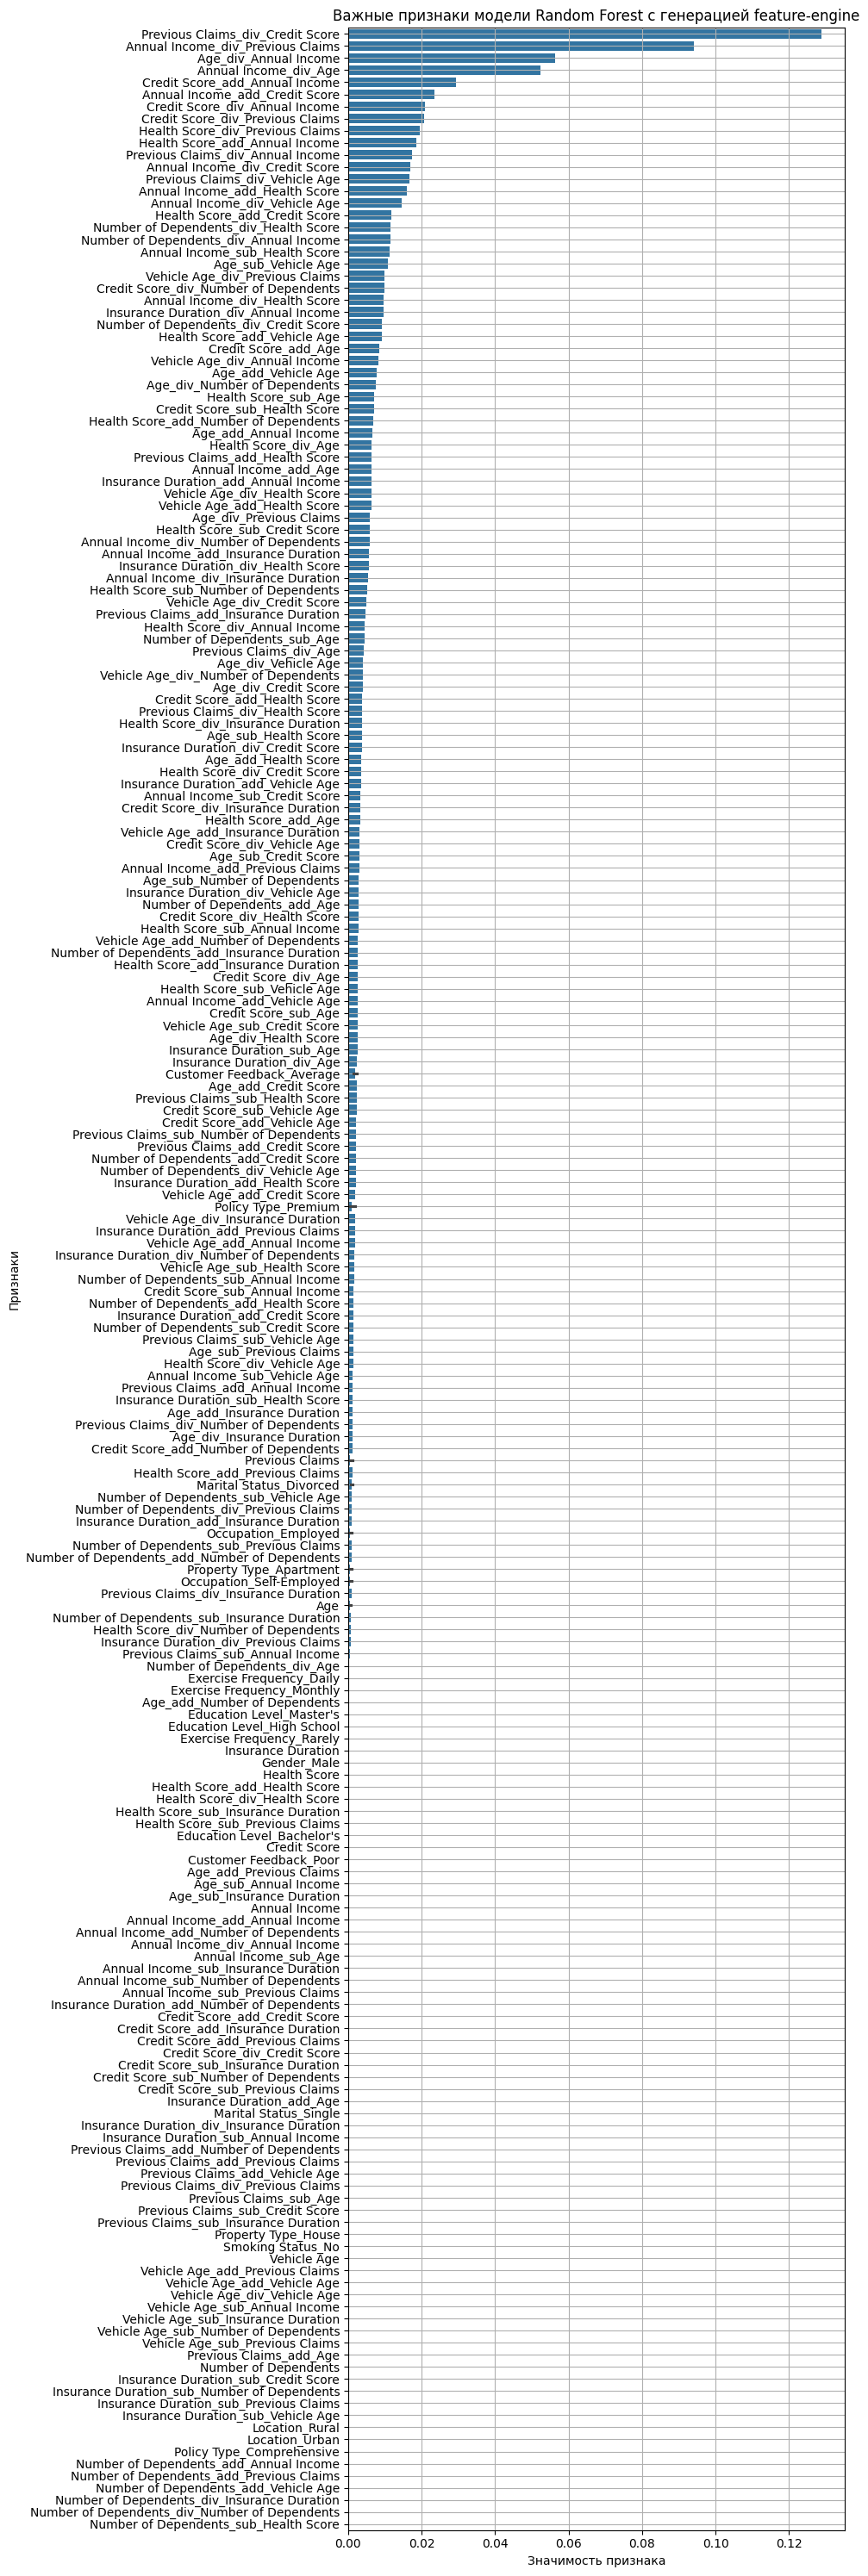

In [53]:
feature_imp_fe = pd.DataFrame(
    sorted(zip(best_rf_reg_fe.feature_importances_, X_final.columns)),
    columns=['Значимость признака','Признаки'])

plt.figure(figsize=(10, 30))
sns.barplot(x="Значимость признака",
            y="Признаки",
            data=feature_imp_fe.sort_values(
                by="Значимость признака",
                ascending=False)
            )
plt.title('Важные признаки модели Random Forest c генерацией feature-engine')
plt.tight_layout()
plt.grid()
plt.show()

Видим, что сгенерированные признаки перетянули на себя одеяло, но насколько это верно - не понятно. Тем более, что метрики качества немного просели и стали хуже.

## Генерация признаков (TSFresh)

Библиотека tsfresh предназначена в первую очередь для работы с временными рядами и извлечения статистических признаков из временных данных. Мы использовали tsfresh.extract_features для извлечения статистических признаков по группам идентификаторов (в нашем случае это столбец id)

In [54]:
X_ts = df_short_ohe.drop(columns=['Premium Amount'])
y = df_short_ohe['Premium Amount']

In [55]:
X_ts.head()

,id,Age,Annual Income,Number of Dependents,Health Score,Previous Claims,Vehicle Age,Credit Score,Insurance Duration,Gender_Male,Marital Status_Married,Marital Status_Single,Education Level_High School,Education Level_Master's,Education Level_PhD,Occupation_Self-Employed,Occupation_Unemployed,Location_Suburban,Location_Urban,Policy Type_Comprehensive,Policy Type_Premium,Customer Feedback_Good,Customer Feedback_Poor,Smoking Status_Yes,Exercise Frequency_Monthly,Exercise Frequency_Rarely,Exercise Frequency_Weekly,Property Type_Condo,Property Type_House
217841,217841,62.0,52086.0,4.0,32.382309,3.0,7.0,462.0,6.0,1,0,1,1,0,0,1,0,0,1,0,1,0,1,0,0,0,0,0,1
1120248,1120248,55.0,63789.0,3.0,45.981148,1.0,10.0,308.0,4.0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,1,0,0,0,0,1
37577,37577,47.0,48262.0,1.0,11.273853,1.0,18.0,340.0,1.0,1,0,1,0,1,0,0,0,0,1,0,1,0,1,0,0,1,0,0,1
1164385,1164385,28.0,2699.0,1.0,30.999345,2.0,0.0,569.0,7.0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,1
84246,84246,40.0,5907.0,1.0,27.527508,1.0,7.0,595.0,6.0,0,1,0,0,1,0,0,0,0,1,0,1,0,1,0,0,0,0,0,1


In [56]:
extracted_features = extract_relevant_features(X_ts[['id','Annual Income','Credit Score', 'Health Score', 'Previous Claims']], 
                                               y, 
                                               column_id='id', 
                                               column_sort="Annual Income") # извлечь признаки

Feature Extraction: 100%|██████████| 40/40 [03:14<00:00,  4.85s/it]


In [57]:
extracted_features.head()

,Previous Claims__benford_correlation,Previous Claims__sum_values,"Previous Claims__fft_coefficient__attr_""real""__coeff_0","Previous Claims__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)","Previous Claims__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)","Previous Claims__cwt_coefficients__coeff_0__w_5__widths_(2, 5, 10, 20)","Previous Claims__cwt_coefficients__coeff_0__w_2__widths_(2, 5, 10, 20)",Previous Claims__quantile__q_0.9,Previous Claims__quantile__q_0.8,Previous Claims__quantile__q_0.7,Previous Claims__quantile__q_0.6,Previous Claims__quantile__q_0.4,Previous Claims__quantile__q_0.3,Previous Claims__quantile__q_0.2,Previous Claims__quantile__q_0.1,Previous Claims__minimum,Previous Claims__absolute_maximum,Previous Claims__maximum,Previous Claims__root_mean_square,Previous Claims__mean,Previous Claims__median,"Previous Claims__fft_coefficient__attr_""abs""__coeff_0",Previous Claims__abs_energy,Credit Score__benford_correlation,Credit Score__sum_values,"Credit Score__fft_coefficient__attr_""real""__coeff_0",Credit Score__abs_energy,Credit Score__median,Credit Score__mean,Credit Score__root_mean_square,Credit Score__maximum,Credit Score__absolute_maximum,Credit Score__minimum,Credit Score__quantile__q_0.1,Credit Score__quantile__q_0.2,Credit Score__quantile__q_0.3,Credit Score__quantile__q_0.4,Credit Score__quantile__q_0.6,Credit Score__quantile__q_0.7,Credit Score__quantile__q_0.8,Credit Score__quantile__q_0.9,"Credit Score__cwt_coefficients__coeff_0__w_2__widths_(2, 5, 10, 20)","Credit Score__cwt_coefficients__coeff_0__w_5__widths_(2, 5, 10, 20)","Credit Score__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)","Credit Score__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)","Credit Score__fft_coefficient__attr_""abs""__coeff_0",Previous Claims__value_count__value_0,Previous Claims__count_below__t_0,Previous Claims__range_count__max_1__min_-1
181,0.864123,0.0,0.0,-0.000000,-0.000000,-0.00000,-0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.241690,770.0,770.0,592900.0,770.0,770.0,770.0,770.0,770.0,770.0,770.0,770.0,770.0,770.0,770.0,770.0,770.0,770.0,417.062485,297.427730,197.319139,139.987234,770.0,1.0,1.0,1.0
405,0.864123,1.0,1.0,0.181802,0.256259,0.38627,0.54164,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,-0.064614,450.0,450.0,202500.0,450.0,450.0,450.0,450.0,450.0,450.0,450.0,450.0,450.0,450.0,450.0,450.0,450.0,450.0,243.737816,173.821401,115.316380,81.810721,450.0,0.0,0.0,0.0
542,0.864123,1.0,1.0,0.181802,0.256259,0.38627,0.54164,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,-0.145280,595.0,595.0,354025.0,595.0,595.0,595.0,595.0,595.0,595.0,595.0,595.0,595.0,595.0,595.0,595.0,595.0,595.0,322.275557,229.830519,152.473880,108.171954,595.0,0.0,0.0,0.0
559,0.864123,0.0,0.0,-0.000000,-0.000000,-0.00000,-0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.064614,420.0,420.0,176400.0,420.0,420.0,420.0,420.0,420.0,420.0,420.0,420.0,420.0,420.0,420.0,420.0,420.0,420.0,227.488628,162.233307,107.628621,76.356673,420.0,1.0,1.0,1.0
583,0.864123,1.0,1.0,0.181802,0.256259,0.38627,0.54164,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,-0.064614,437.0,437.0,190969.0,437.0,437.0,437.0,437.0,437.0,437.0,437.0,437.0,437.0,437.0,437.0,437.0,437.0,437.0,236.696501,168.799894,111.985018,79.447301,437.0,0.0,0.0,0.0


In [58]:
extracted_features.isna().sum()

Previous Claims__benford_correlation                                       0
Previous Claims__sum_values                                                0
Previous Claims__fft_coefficient__attr_"real"__coeff_0                     0
Previous Claims__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)    0
Previous Claims__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)    0
Previous Claims__cwt_coefficients__coeff_0__w_5__widths_(2, 5, 10, 20)     0
Previous Claims__cwt_coefficients__coeff_0__w_2__widths_(2, 5, 10, 20)     0
Previous Claims__quantile__q_0.9                                           0
Previous Claims__quantile__q_0.8                                           0
Previous Claims__quantile__q_0.7                                           0
Previous Claims__quantile__q_0.6                                           0
Previous Claims__quantile__q_0.4                                           0
Previous Claims__quantile__q_0.3                                           0

In [59]:
extracted_features.describe().T

,count,mean,std,min,25%,50%,75%,max
Previous Claims__benford_correlation,10000.0,0.740235,0.257995,-0.200946,0.864123,0.864123,0.864123,0.864123
Previous Claims__sum_values,10000.0,1.006500,0.813956,0.000000,0.000000,1.000000,1.000000,6.000000
"Previous Claims__fft_coefficient__attr_""real""__coeff_0",10000.0,1.006500,0.813956,0.000000,0.000000,1.000000,1.000000,6.000000
"Previous Claims__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)",10000.0,0.182983,0.147978,-0.000000,-0.000000,0.181802,0.181802,1.090810
"Previous Claims__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)",10000.0,0.257924,0.208583,-0.000000,-0.000000,0.256259,0.256259,1.537552
"Previous Claims__cwt_coefficients__coeff_0__w_5__widths_(2, 5, 10, 20)",10000.0,0.388781,0.314407,-0.000000,-0.000000,0.386270,0.386270,2.317619
"Previous Claims__cwt_coefficients__coeff_0__w_2__widths_(2, 5, 10, 20)",10000.0,0.545160,0.440871,-0.000000,-0.000000,0.541640,0.541640,3.249838
Previous Claims__quantile__q_0.9,10000.0,1.006500,0.813956,0.000000,0.000000,1.000000,1.000000,6.000000
Previous Claims__quantile__q_0.8,10000.0,1.006500,0.813956,0.000000,0.000000,1.000000,1.000000,6.000000
Previous Claims__quantile__q_0.7,10000.0,1.006500,0.813956,0.000000,0.000000,1.000000,1.000000,6.000000


In [60]:
X_train_ts, X_test_ts, y_train_ts, y_test_ts = train_test_split(extracted_features, y, test_size=0.2, random_state=42)

print('Размер тренировочной выборки (признаки):', X_train_ts.shape)
print('Размер тестовой выборки (признаки):', X_test_ts.shape)
print('Размер тренировочной выборки (целевой признак):', y_train_ts.shape)
print('Размер тестовой выборки (целевой признак):', y_test_ts.shape)

Размер тренировочной выборки (признаки): (8000, 49)
Размер тестовой выборки (признаки): (2000, 49)
Размер тренировочной выборки (целевой признак): (8000,)
Размер тестовой выборки (целевой признак): (2000,)


### RandomForestRegressor (со сгенерированными признаками tsfresh)

In [61]:
# Создаем модель случайного леса
rf_model_ts = RandomForestRegressor(random_state=42)

# Создаем объект RandomizedSearchCV c сеткой параметров
random_search_rf_ts = RandomizedSearchCV(
    rf_model_ts,
    param_grid_rf,
    n_iter=30, 
    cv=3,  
    scoring='neg_mean_squared_error',
    n_jobs=-1,  
    random_state=42
)

# Запускаем подбор параметров
random_search_rf_ts.fit(X_train_ts, y_train_ts)

# Выводим лучшие параметры
print("Лучшие параметры:", random_search_rf_ts.best_params_)

# Финальная модель
best_rf_reg_ts = random_search_rf_ts.best_estimator_

Лучшие параметры: {'min_samples_split': 4, 'min_samples_leaf': 4, 'max_depth': 3, 'ccp_alpha': 0.01}


In [62]:
rf_pred_best_ts = best_rf_reg_ts.predict(X_test_ts)

In [63]:
# Оценка качества
mse_rf_ts = mean_squared_error(y_test_ts, rf_pred_best_ts)
rmse_rf_ts = root_mean_squared_error(y_test_ts, rf_pred_best_ts)
r2_rf_ts = r2_score(y_test_ts, rf_pred_best_ts)
mae_rf_ts = mean_absolute_error(y_test_ts, rf_pred_best_ts)

print('MSE (c генерацией признаков):', mse_rf_ts)
print('RMSE (c генерацией признаков):', rmse_rf_ts)
print('R2 (c генерацией признаков):', r2_rf_ts)
print('MAE (c генерацией признаков):', mae_rf_ts)

MSE (c генерацией признаков): 730082.5253409898
RMSE (c генерацией признаков): 854.4486674698427
R2 (c генерацией признаков): -0.0001778444986193506
MAE (c генерацией признаков): 663.9250359705919


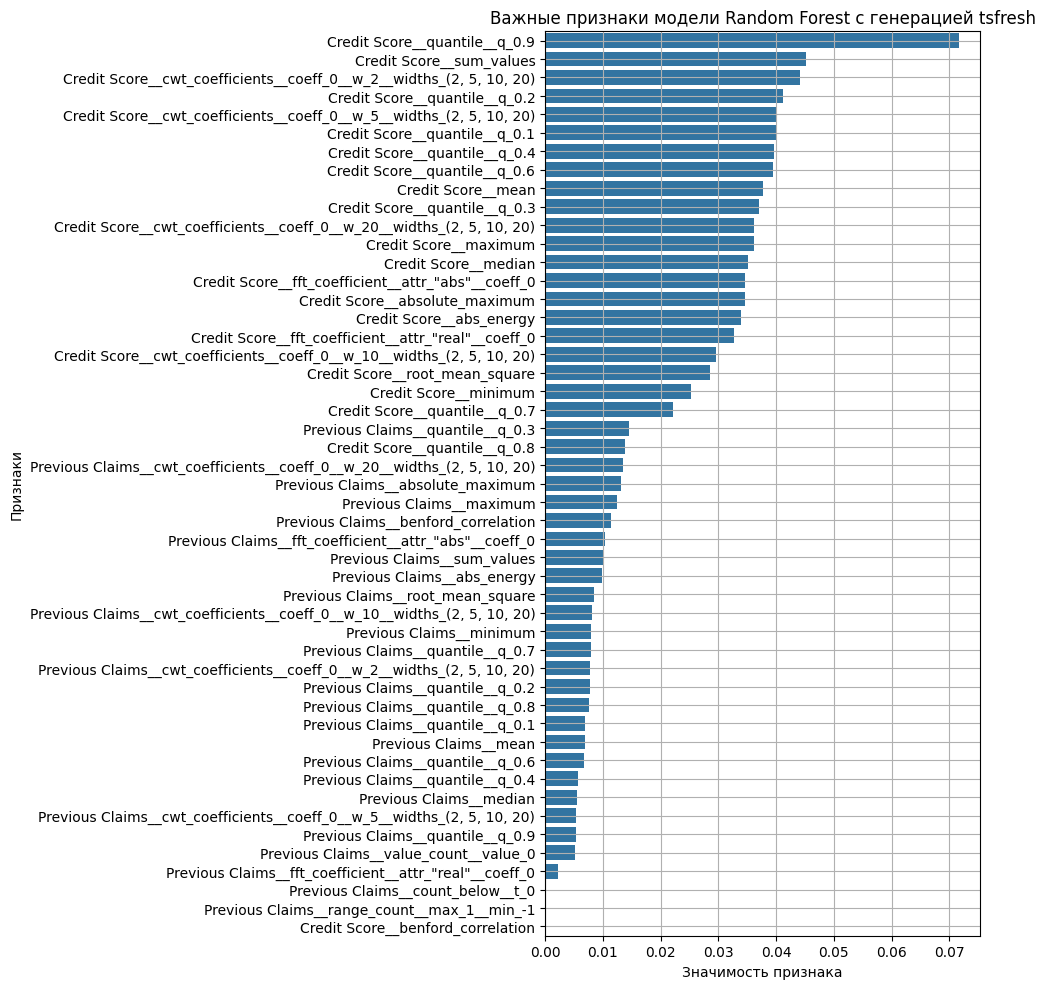

In [64]:
feature_imp_ts = pd.DataFrame(
    sorted(zip(best_rf_reg_ts.feature_importances_, extracted_features.columns)),
    columns=['Значимость признака','Признаки'])

plt.figure(figsize=(10, 10))
sns.barplot(x="Значимость признака",
            y="Признаки",
            data=feature_imp_ts.sort_values(
                by="Значимость признака",
                ascending=False)
            )
plt.title('Важные признаки модели Random Forest с генерацией tsfresh')
plt.tight_layout()
plt.grid()
plt.show()

## Общая таблица по метрикам

In [65]:
pd.set_option('display.max_colwidth', None)
pd.DataFrame(
    {'MSE': [
        mse_rf,
        mse_rf_fe,
        mse_rf_ts
    ],
     'RMSE': [
        rmse_rf,
        rmse_rf_fe,
        rmse_rf_ts
    ],
     'R2': [
        r2_rf,
        r2_rf_fe,
        r2_rf_ts
    ],
     'MAE': [
        mae_rf,
        mae_rf_fe,
        mae_rf_ts
    ]
    },
    index=[
        'RandomForest без генерации признаков',
        'RandomForest с генерацией feature-engine',
        'RandomForest с генерацией tsfresh'
    ]
)

,MSE,RMSE,R2,MAE
RandomForest без генерации признаков,710322.856487,842.806536,0.026892,649.031111
RandomForest с генерацией feature-engine,719431.960188,848.193351,0.014413,656.978840
RandomForest с генерацией tsfresh,730082.525341,854.448667,-0.000178,663.925036


В данной задаче генерация новых признаков не помогла улучшить метрики качества модели. Генерация признаков более подходит задачам с временными рядами.